# Script for Model Training and Application to Unseen, Target Data Frame 

In [ ]:
#Import all necessary modules
import tqdm 
import pandas as pd
!pip3 install simpletransformers 
import simpletransformers
!pip3 install transformers
import transformers
!pip3 install seqeval
import seqeval

import io
import matplotlib 
import matplotlib.pyplot as pl
import nltk
from google.colab import files

import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np
from sklearn.model_selection import train_test_split

from simpletransformers.classification import MultiLabelClassificationModel
import torch
from sklearn.metrics import classification_report


##PART 1: Train model 

In [ ]:
#upload annotated dataset
uploaded = files.upload()

In [ ]:
df = pd.read_csv(io.BytesIO(uploaded['trainset2.csv']), header=0, sep=';')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8663 entries, 0 to 8662
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   0        8370 non-null   object 
 1   Text     8663 non-null   object 
 2   EconPo   8505 non-null   object 
 3   Obj      8529 non-null   float64
 4   Scien    8509 non-null   object 
 5   FamVal   93 non-null     float64
 6   GenDi    8486 non-null   float64
 7   PovConc  8529 non-null   float64
dtypes: float64(4), object(4)
memory usage: 541.6+ KB


In [ ]:
df = df[df.EconPo!= '-']
df = df[df.Scien!= 'Q']

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8661 entries, 0 to 8662
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   0        8368 non-null   object 
 1   Text     8661 non-null   object 
 2   EconPo   8503 non-null   object 
 3   Obj      8527 non-null   float64
 4   Scien    8507 non-null   object 
 5   FamVal   93 non-null     float64
 6   GenDi    8484 non-null   float64
 7   PovConc  8527 non-null   float64
dtypes: float64(4), object(4)
memory usage: 609.0+ KB


In [ ]:
#fill empty label columns with 0
df['EconPo'] = df['EconPo'].fillna(0)
df['Scien'] = df['Scien'].fillna(0)
df['Obj'] = df['Obj'].fillna(0)
df['GenDi'] = df['GenDi'].fillna(0)
df['PovConc'] = df['PovConc'].fillna(0)
df['FamVal'] = df['FamVal'].fillna(0)

In [ ]:
df['EconPo'] = pd.to_numeric(df['EconPo'])
df['Scien'] = pd.to_numeric(df['Scien'])


1.1 Download random sample for intercoder reliability

In [ ]:
#reltest = df.sample(n=80) 

In [ ]:
#reltest.to_csv('reltest.csv')
#files.download('reltest.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1.2. Clean dataframe before model training 

In [ ]:
#small letters
df['Text'].str.lower()
#Replace Umlauts (important for German text)
df['Text'] = df['Text'].str.replace(u'ä', 'ae')
df['Text'] = df['Text'].str.replace(u'ö', 'oe')
df['Text'] = df['Text'].str.replace(u'ü', 'ue')
#Remove stopwords
df['Text'] = df['Text'].astype(str)
#German stopwords
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = list(set(stopwords.words('german')))
newStopWords = ['fuer','familie','schweiz', 'kindern', 'kinder', 'familien','sind', 'eben', 'ist', 'koennen', 'koennte','sollen', 'muessen', 'kann', 'soll', 'muss', 'million', 'millionen', 'franken', 'werden', 'wird', 'Familien','-','ueber','sei','sein','seid', 'geht','werden','haben','beim','gibt','haben','bund','herr','hat','bundesrat','schon','ja', 'moechte', 'moechten','nein','unser','unserer','euer', 'eure','page','bitte','erster','ersten', 'dafuer','sie','ihr','sagen','fragen','nicht','sein','sind','1','2','3']
stop_words.extend(newStopWords)
def stop_word_removal(x):
    token = x.split()
    return ' '.join([w for w in token if not w in stop_words])
#df['Text']  = df['Text'].apply(stop_word_removal) #- performs worse with stopword removal 
#remove punctuation
df['Text'] = df['Text'].str.replace(r'[^\w\s]+', '')
#Remove numbers
df['Text'].str.replace('\d+', '')
#remove words smaller than 1 (due to 'p' appearing)
df['Text'] = df.Text.apply(lambda x :" ".join([i for i in x.split() if len(i)>1]))
df['Text'] = df['Text'].str.replace('</p>', '')
df['Text'] = df['Text'].str.replace('</i>', '')
df['Text'] = df['Text'].str.replace(' pp', '')
df['Text'] = df['Text'].str.replace('pp ', '')



1.3. Descriptive statistics of training dataset



In [ ]:
len(df)

8661

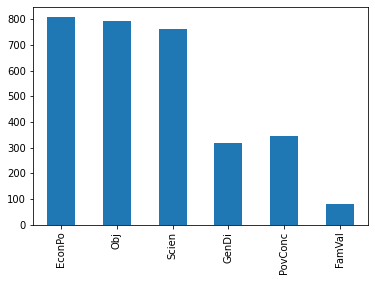

In [ ]:
#Label frequency
#descriptive statistics of label frequency
plotlabs = df[["EconPo", "Obj", "Scien", "GenDi", "PovConc", "FamVal"]]
plotlabs.sum(axis=0).plot.bar()
#imbalanced dataset, so adding weights to the model later helps to improve performance

In [ ]:
#Most common words
#remove stopwords for work counter, by creating a new dataframe 
dfs= = dfs['Text'].apply(stop_word_removal) #- performs worse with stopword removal 
#most common words
from collections import Counter
Counter(" ".join(dfs).split()).most_common(100)

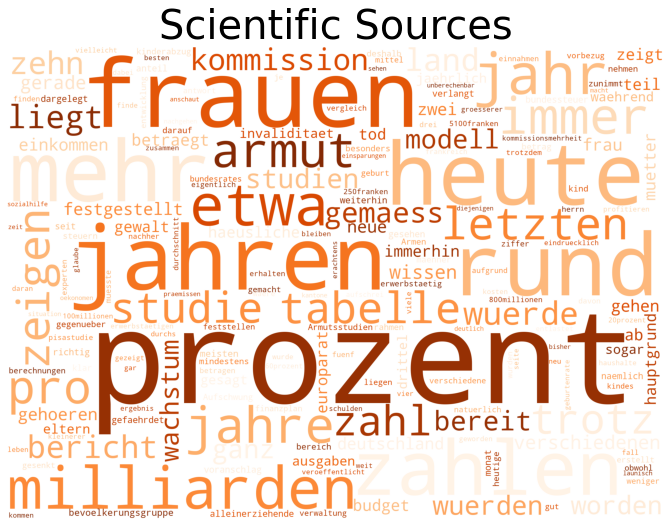

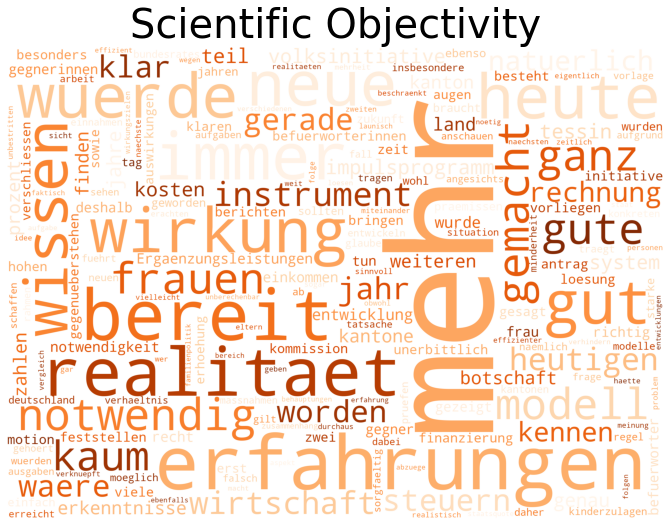

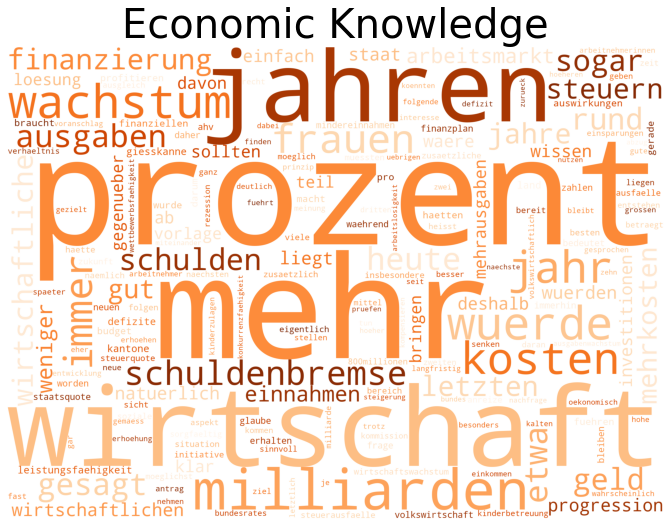

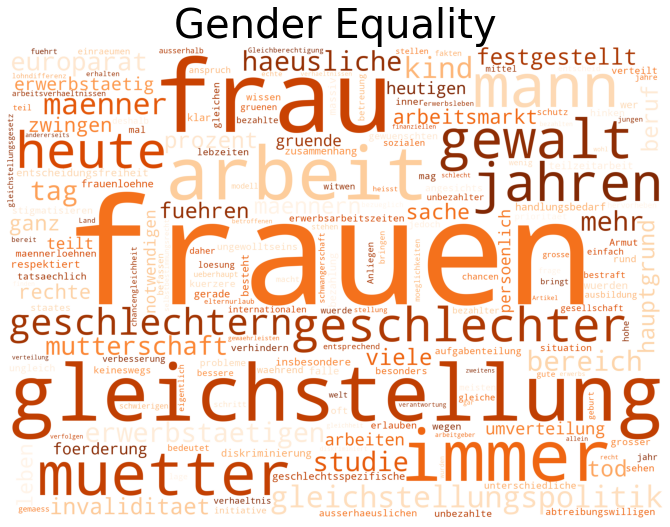

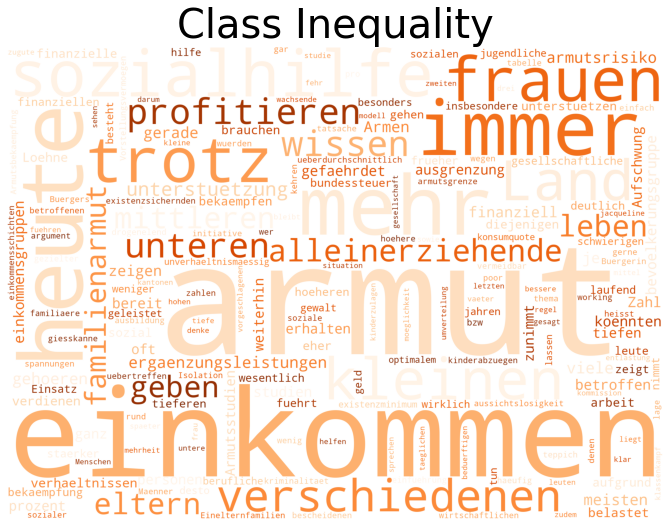

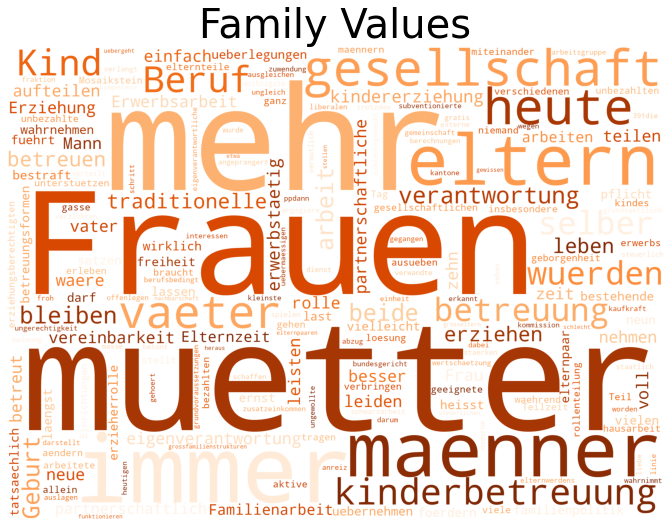

In [ ]:
#Wordcloud of most common words (minus stop_words), code from  
# Scien
subset = df[df.Scien==1]
text = subset.Text.values
cloud_scien = WordCloud(
                          stopwords=stop_words,
                          background_color='white',
                        colormap="Oranges",
                          collocations=False,
                          width=2500,
                          height=1800
                         ).generate(" ".join(text))

plt.figure(figsize=(40,25))
plt.subplot(2, 3, 2)
plt.axis('off')
plt.title("Scientific Sources",fontsize=40)
plt.imshow(cloud_scien)

# Obj
subset = df[df.Obj==1]
text = subset.Text.values
cloud_scien = WordCloud(
                          stopwords=stop_words,
                          background_color='white',
                                               colormap="Oranges",
                          collocations=False,
                          width=2500,
                          height=1800
                         ).generate(" ".join(text))

plt.figure(figsize=(40,25))
plt.subplot(2, 3, 2)
plt.axis('off')
plt.title("Scientific Objectivity",fontsize=40)
plt.imshow(cloud_scien)




# EconPo
subset = df[df.EconPo==1]
text = subset.Text.values
cloud_econpo = WordCloud(
                          stopwords=stop_words,
                          background_color='white',
                                                colormap="Oranges",
                          collocations=False,
                          width=2500,
                          height=1800
                         ).generate(" ".join(text))

plt.figure(figsize=(40,25))
plt.subplot(2, 3, 1)
plt.axis('off')
plt.title("Economic Knowledge",fontsize=40)
plt.imshow(cloud_econpo)



# obscene
subset = df[df.GenDi==1]
text = subset.Text.values
cloud_GenDi = WordCloud(
                          stopwords=stop_words,
                          background_color='white',
                                               colormap="Oranges",
                          collocations=False,
                          width=2500,
                          height=1800
                         ).generate(" ".join(text))

plt.figure(figsize=(40,25))
plt.subplot(2, 3, 3)
plt.axis('off')
plt.title("Gender Equality",fontsize=40)
plt.imshow(cloud_GenDi)


# PovConc
subset = df[df.PovConc==1]
text = subset.Text.values
cloud_PovConc = WordCloud(
                          stopwords=stop_words,
                          background_color='white',
                                                 colormap="Oranges",
                          collocations=False,
                          width=2500,
                          height=1800
                         ).generate(" ".join(text))
plt.figure(figsize=(40,25))
plt.subplot(2, 3, 4)
plt.axis('off')
plt.title("Class Inequality",fontsize=40)
plt.imshow(cloud_PovConc)

# FamVal
subset = df[df.FamVal==1]
text = subset.Text.values
cloud_FamVal = WordCloud(
                          stopwords=stop_words,
                          background_color='white',
                                                 colormap="Oranges",
                          collocations=False,
                          width=2500,
                          height=1800
                         ).generate(" ".join(text))
plt.figure(figsize=(40,25))
plt.subplot(2, 3, 4)
plt.axis('off')
plt.title("Family Values",fontsize=40)
plt.imshow(cloud_FamVal)

plt.show()

In [ ]:
df["Text"]=df["Text"].str.replace("-"," ")
df['text'] = df['Text'].apply(lambda x: x.replace('\n', ' '))

In [ ]:
#convert columns to correct data type
df['labels'] = list(zip(df.EconPo.tolist(), df.Obj.tolist(), df.Scien.tolist(), df.GenDi.tolist(), df.PovConc.tolist()))


1.4. Split dataset and train model 

For training the model, I used the simpletransformers library and parts of a script by GitHub user @ThilinaRajapakse. 

In [ ]:
#stratify labels in dataset split, function source: @grofte
!pip3 install scikit-multilearn
from skmultilearn.model_selection import IterativeStratification

def iterative_split(df, test_size, stratify_columns):
    """Custom iterative train test split which
    'maintains balanced representation with respect
    to order-th label combinations.'

    From https://madewithml.com/courses/mlops/splitting/#stratified-split
    """
    # One-hot encode the stratify columns and concatenate them
    one_hot_cols = [pd.get_dummies(df[col]) for col in stratify_columns]
    one_hot_cols = pd.concat(one_hot_cols, axis=1).to_numpy()
    stratifier = IterativeStratification(
        n_splits=2, order=len(stratify_columns), sample_distribution_per_fold=[test_size, 1-test_size])
    train_indices, test_indices = next(stratifier.split(df.to_numpy(), one_hot_cols))
    # Return the train and test set dataframes
    train, test = df.iloc[train_indices], df.iloc[test_indices]
    return train, test


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 89 kB 5.2 MB/s 


In [ ]:
train, test = iterative_split(df, 0.2, ['EconPo','Obj','Scien','GenDi','PovConc','FamVal'])

In [ ]:
#split dataset into training and evaluation dataset, set seed for reproducibility. Possible to also stratify labels. 
#train_df, eval_df = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
#calculate weight 
positive_weights = {}
negative_weights = {}
for p in plotlabs:
    positive_weights[p] = train_df.shape[0]/(2*np.count_nonzero(train_df[p]==1))
    negative_weights[p] = train_df.shape[0]/(2*np.count_nonzero(train_df[p]==0))
print(positive_weights)
print(negative_weights)

{'EconPo': 5.33026113671275, 'Obj': 5.028985507246377, 'Scien': 7.214137214137214, 'GenDi': 15.772727272727273, 'PovConc': 13.397683397683398}
{'EconPo': 0.5518447837150128, 'Obj': 0.5552, 'Scien': 0.5372348660783403, 'GenDi': 0.5163690476190477, 'PovConc': 0.5193833258494237}


In [ ]:
#create weights
weights = [0.552, 0.552, 0.537, 0.51, 0.5193]
#Note: my model performed WORSE with weights and better with stratified train-test-split

In [ ]:
#specificy model, pre-trained German model selected from huggingface (parameters adjusted for best performance and according to computers capabilities)
#more information on model, here: https://huggingface.co/dbmdz/bert-base-german-uncased
model = MultiLabelClassificationModel('bert', 'bert-base-german-dbmdz-uncased', num_labels=5, args={'train_batch_size':8, 'gradient_accumulation_steps':16, 'learning_rate': 0.0001, 'num_train_epochs': 24, 'max_seq_length': 512, "early_stopping": True})

In [ ]:
torch.cuda.empty_cache()
overwrite_output_dir: True

In [ ]:
# Train the model
from google.colab import output
output.enable_custom_widget_manager()
model.train_model(train)

  0%|          | 0/6929 [00:00<?, ?it/s]

Epoch:   0%|          | 0/24 [00:00<?, ?it/s]

Running Epoch 0 of 24:   0%|          | 0/867 [00:00<?, ?it/s]

Running Epoch 1 of 24:   0%|          | 0/867 [00:00<?, ?it/s]

Running Epoch 2 of 24:   0%|          | 0/867 [00:00<?, ?it/s]

Running Epoch 3 of 24:   0%|          | 0/867 [00:00<?, ?it/s]

Running Epoch 4 of 24:   0%|          | 0/867 [00:00<?, ?it/s]

Running Epoch 5 of 24:   0%|          | 0/867 [00:00<?, ?it/s]

Running Epoch 6 of 24:   0%|          | 0/867 [00:00<?, ?it/s]

Running Epoch 7 of 24:   0%|          | 0/867 [00:00<?, ?it/s]

Running Epoch 8 of 24:   0%|          | 0/867 [00:00<?, ?it/s]

Running Epoch 9 of 24:   0%|          | 0/867 [00:00<?, ?it/s]

Running Epoch 10 of 24:   0%|          | 0/867 [00:00<?, ?it/s]

Running Epoch 11 of 24:   0%|          | 0/867 [00:00<?, ?it/s]

Running Epoch 12 of 24:   0%|          | 0/867 [00:00<?, ?it/s]

Running Epoch 13 of 24:   0%|          | 0/867 [00:00<?, ?it/s]

Running Epoch 14 of 24:   0%|          | 0/867 [00:00<?, ?it/s]

Running Epoch 15 of 24:   0%|          | 0/867 [00:00<?, ?it/s]

Running Epoch 16 of 24:   0%|          | 0/867 [00:00<?, ?it/s]

Running Epoch 17 of 24:   0%|          | 0/867 [00:00<?, ?it/s]

Running Epoch 18 of 24:   0%|          | 0/867 [00:00<?, ?it/s]

Running Epoch 19 of 24:   0%|          | 0/867 [00:00<?, ?it/s]

Running Epoch 20 of 24:   0%|          | 0/867 [00:00<?, ?it/s]

Running Epoch 21 of 24:   0%|          | 0/867 [00:00<?, ?it/s]

Running Epoch 22 of 24:   0%|          | 0/867 [00:00<?, ?it/s]

Running Epoch 23 of 24:   0%|          | 0/867 [00:00<?, ?it/s]

(1296, 0.036462382071065655)

In [ ]:
# Save the entire model as a SavedModel to use later. 
model.save_model ("gdrive/My Drive")

1.5. Evaluate model 

In [ ]:
result, model_outputs, wrongs_predictions = model.eval_model(test)


  0%|          | 0/1732 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/217 [00:00<?, ?it/s]

In [ ]:
result

{'LRAP': 0.9669745958429562, 'eval_loss': 0.2417413928825113}

In [ ]:
#create classification report for f1 score and recall. 
evallabs = test[["EconPo", "Obj", "Scien", "GenDi", "PovConc"]]
predictions = np.around(model_outputs)
true = np.around(evallabs)
print(classification_report(true, predictions), )

              precision    recall  f1-score   support

           0       0.60      0.62      0.61       161
           1       0.57      0.53      0.55       159
           2       0.72      0.73      0.72       153
           3       0.71      0.76      0.74        66
           4       0.81      0.83      0.82        69

   micro avg       0.66      0.66      0.66       608
   macro avg       0.68      0.69      0.69       608
weighted avg       0.66      0.66      0.66       608
 samples avg       0.19      0.19      0.19       608



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1.6. Sample predictions 
(try model on new, unseen sentences)

In [ ]:
# Sample test q
predictions, raw_outputs = model.predict(["die armen leiden daran, dass sehen wir an den zahlen"])

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
predictions #correct

[[0, 0, 1, 0, 1, 0]]

In [ ]:
# Sample test q
predictions2, raw_outputs = model.predict(["diesen volkswirtschaftlichen und wirtschaftspolitischen überlegungen schliesse ich mich an."])

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
predictions2 # correct

[[1, 0, 0, 0, 0, 0]]

In [ ]:
#Sample test 3

In [ ]:
predictions, raw_outputs = model.predict(["es gibt nach wie vor zahlreiche frauen, die im teilpensum einer bezahlten arbeit nachgehen und diskriminiert werden."])

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
predictions #correct

[[0, 0, 0, 1, 0, 0]]

In [ ]:
len(wrong_predictions)

In [ ]:
predictions, raw_outputs = model.predict(["kinderbetreuung ist gut für die wirtschaft, wie berechnungen beweisen"])
predictions #correct

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[[1, 0, 1, 0, 0, 0]]

In [ ]:
raw_outputs

array([[0.99658203, 0.15637207, 0.95214844, 0.01098633, 0.00475693]])

In [ ]:
predictions, raw_outputs = model.predict(["eine entscheidende voraussetzung dafür, dass die erwerbsbeteiligung der frauen immer anstieg und damit auch ein Stück gleichstellung der geschlechter realisiert wurde, ist das vorhandensein von einrichtungen zur familienexternen kinderbetreuung."])
predictions # correct

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[[0, 0, 0, 1, 0, 0]]

In [ ]:
predictions, raw_outputs = model.predict(["das ist keine frage der ideologie, sondern der wissenschaft"])
predictions #correct 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[[0, 1, 0, 0, 0, 0]]

## PART 2: Run Model on Target Data


2.1. Load target data
(for script on data collection, see: XX)

In [ ]:
#import modules 
from google.colab import files
from google.colab import drive
import numpy as np

In [ ]:
uploaded = files.upload()

In [ ]:
target = pd.read_csv(io.BytesIO(uploaded['target_final.csv']), header=0, sep=';')

In [ ]:
#add data from google drive to colab
drive.mount('/content/drive')

In [ ]:
%cd /content/drive/My Drive/Colab Notebooks/

/content/drive/My Drive/Colab Notebooks


2.1. Pre-process dataset, same as training dataset earlier

In [ ]:
#small letters
target['Text'].str.lower()
#Replace Umlauts
target['Text'] = target['Text'].str.replace(u'ä', 'ae')
target['Text'] = target['Text'].str.replace(u'ö', 'oe')
target['Text'] = target['Text'].str.replace(u'ü', 'ue')
#Remove stopwords
target['Text'] = target['Text'].astype(str)
#German stopwords
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = list(set(stopwords.words('german')))
newStopWords = ['fuer','familie','schweiz', 'kindern', 'kinder', 'familien','sind', 'ist', 'koennen', 'sollen', 'muessen', 'kann', 'soll', 'million', 'millionen', 'franken', 'werden', 'wird', 'Familien','-','ueber','sei','sein','seid', 'geht','werden','haben','beim','gibt','haben','bund','herr','hat','bundesrat','schon','ja','nein','unser','unserer','euer', 'eure','page','bitte','erster','ersten', 'dafuer','sie','ihr','sagen','fragen','nicht','sein','sind']
stop_words.extend(newStopWords)
def stop_word_removal(x):
    token = x.split()
    return ' '.join([w for w in token if not w in stop_words])
#target['Text']  = target['Text'].apply(stop_word_removal)
#German lemmatization (optional)
#!pip3 install german-lemmatizer
#import german_lemmatizer
#from german_lemmatizer import lemmatize
#lemmatize(target['Text'])
#delete dot after number
target['Text'].str.replace(r"^(\d+)\.$", r"\1")
target['Text'] = target.Text.apply(lambda x :" ".join([i for i in x.split() if len(i)>1]))
#delete <p>
target['Text'] = target['Text'].str.replace('</p>', '')
target['Text'] = target['Text'].str.replace('</i>', '')
target['Text'] = target['Text'].str.replace(' pp', '')
target['Text'] = target['Text'].str.replace('pp ', '')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: FutureWarning: The default value of regex will change from True to False in a future version.


In [ ]:
#Delete all NaNs 
#delete rows where NaN
target['Text'] = target['Text'].replace('NaN', np.nan)
target = target[target['Text'].notna()]

In [ ]:
#Split text into sentences, as model was also trained on sentences.
target['Text'] = target['Text'].str.split('.')
target = target.explode('Text')

In [ ]:
target

,Unnamed: 0,ID,Language,IdSubject,PersonNumber,Text,MeetingCouncilAbbreviation,IdSession,SpeakerFullName,CantonAbbreviation,ParlGroupName,ParlGroupAbbreviation,yy,MeetingDate,CouncilName
0,0,17661,DE,3316.0,456.0,unser antrag betrifft artikel 9b und zwar die ...,N,4611.0,Cina Jean-Michel,VS,Christlichdemokratische Fraktion,C,2001.0,NaN,NaN
0,0,17661,DE,3316.0,456.0,ppder vom bundesrat neu eingefuegte artikel 9b...,N,4611.0,Cina Jean-Michel,VS,Christlichdemokratische Fraktion,C,2001.0,NaN,NaN
0,0,17661,DE,3316.0,456.0,"versicherten, die aufgrund von erziehungszeit...",N,4611.0,Cina Jean-Michel,VS,Christlichdemokratische Fraktion,C,2001.0,NaN,NaN
0,0,17661,DE,3316.0,456.0,durch die differenzierte regelung der rahmenf...,N,4611.0,Cina Jean-Michel,VS,Christlichdemokratische Fraktion,C,2001.0,NaN,NaN
0,0,17661,DE,3316.0,456.0,"es ist klar, dass es sich dabei um personen h...",N,4611.0,Cina Jean-Michel,VS,Christlichdemokratische Fraktion,C,2001.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4743,4754,277902,NaN,51882.0,4213.0,diese diskriminierung wurde mit 13 gegen 11 s...,N,NaN,Bendahan Samuel,VD,Groupe socialiste,S,2021.0,20210308.0,Conseil national
4743,4754,277902,NaN,51882.0,4213.0,"damit wir aus dieser pandemie herauskommen, d...",N,NaN,Bendahan Samuel,VD,Groupe socialiste,S,2021.0,20210308.0,Conseil national
4743,4754,277902,NaN,51882.0,4213.0,so verteidigt unser ausschuss seine mehrheits...,N,NaN,Bendahan Samuel,VD,Groupe socialiste,S,2021.0,20210308.0,Conseil national
4743,4754,277902,NaN,51882.0,4213.0,"ich fordere sie auf, sie zu unterstuetzen und...",N,NaN,Bendahan Samuel,VD,Groupe socialiste,S,2021.0,20210308.0,Conseil national


In [ ]:
#splitting was imperfect, re-adjust dataframe 
#Delete all NaNs 
#delete rows where NaN (algorithm marks them as all)
target['Text'] = target['Text'].replace('NaN', np.nan)
target = target[target['Text'].notna()]
target['Text'] = target['Text'].replace('nan', np.nan)
target = target[target['Text'].notna()]

In [ ]:
#split target dataset into sentences, since model was trained on 
#target = target[target['Text'].str.strip().astype(bool)]

In [ ]:
#remove punctuation
target['Text'] = target['Text'].str.replace(r'[^\w\s]+', '')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [ ]:
target['Text'] = target['Text'].str.lower()
target['Text'] = target['Text'].astype(str)
target['Text'] = target['Text'].apply(lambda x: x.replace('\n', ' '))

In [ ]:
len(target)

147689

In [ ]:
target.drop_duplicates(subset='Text', keep="last")

2.2 Run model on target dataset

In [ ]:
to_predict = target.Text.apply(lambda x: x.replace('\n', ' ')).tolist()

In [ ]:
preds, outputs = model.predict(to_predict)

  0%|          | 0/147689 [00:00<?, ?it/s]

  0%|          | 0/18462 [00:00<?, ?it/s]

In [ ]:
#create df with predictions
preds = pd.DataFrame(preds, columns=['EconPo','Obj','Scien','GenDi','PovConc'])


In [ ]:
preds

,EconPo,Obj,Scien,GenDi,PovConc
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0
...,...,...,...,...,...
147684,0,0,0,0,0
147685,0,0,0,0,0
147686,0,0,0,0,0
147687,0,0,0,0,0


In [ ]:
targeted = target.reset_index()

In [ ]:
#combine target dataset with predictions
df_concat = pd.concat([targeted, preds], axis = 1)

In [ ]:
df_concat

,index,Unnamed: 0,ID,Language,IdSubject,PersonNumber,Text,MeetingCouncilAbbreviation,IdSession,SpeakerFullName,...,ParlGroupName,ParlGroupAbbreviation,yy,MeetingDate,CouncilName,EconPo,Obj,Scien,GenDi,PovConc
0,0,0,17661,DE,3316.0,456.0,unser antrag betrifft artikel 9b und zwar die ...,N,4611.0,Cina Jean-Michel,...,Christlichdemokratische Fraktion,C,2001.0,NaN,NaN,0,0,0,0,0
1,0,0,17661,DE,3316.0,456.0,ppder vom bundesrat neu eingefuegte artikel 9b...,N,4611.0,Cina Jean-Michel,...,Christlichdemokratische Fraktion,C,2001.0,NaN,NaN,0,0,0,0,0
2,0,0,17661,DE,3316.0,456.0,versicherten die aufgrund von erziehungszeite...,N,4611.0,Cina Jean-Michel,...,Christlichdemokratische Fraktion,C,2001.0,NaN,NaN,0,0,0,0,0
3,0,0,17661,DE,3316.0,456.0,durch die differenzierte regelung der rahmenf...,N,4611.0,Cina Jean-Michel,...,Christlichdemokratische Fraktion,C,2001.0,NaN,NaN,0,0,0,0,0
4,0,0,17661,DE,3316.0,456.0,es ist klar dass es sich dabei um personen ha...,N,4611.0,Cina Jean-Michel,...,Christlichdemokratische Fraktion,C,2001.0,NaN,NaN,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147684,4743,4754,277902,NaN,51882.0,4213.0,diese diskriminierung wurde mit 13 gegen 11 s...,N,NaN,Bendahan Samuel,...,Groupe socialiste,S,2021.0,20210308.0,Conseil national,0,0,0,0,0
147685,4743,4754,277902,NaN,51882.0,4213.0,damit wir aus dieser pandemie herauskommen du...,N,NaN,Bendahan Samuel,...,Groupe socialiste,S,2021.0,20210308.0,Conseil national,0,0,0,0,0
147686,4743,4754,277902,NaN,51882.0,4213.0,so verteidigt unser ausschuss seine mehrheits...,N,NaN,Bendahan Samuel,...,Groupe socialiste,S,2021.0,20210308.0,Conseil national,0,0,0,0,0
147687,4743,4754,277902,NaN,51882.0,4213.0,ich fordere sie auf sie zu unterstuetzen und ...,N,NaN,Bendahan Samuel,...,Groupe socialiste,S,2021.0,20210308.0,Conseil national,0,0,0,0,0


In [ ]:
#download for hand evaluation
#df_concat = pd.concat([target, preds], axis=1)
#df_concat
reltesttarget = df_concat.sample(n=100) 
reltesttarget.to_csv('reltesttarget.csv')
files.download('reltesttarget.csv')
#save full frame
#df_concat.to_csv('concattargetpersentence.csv')
#files.download('concattargetpersentence.csv')
#save sample for hand evaluation


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#merge rows with same ID together and sum up prediction columns

In [ ]:
#group sentences back together and aggregate predictions
df2 = df_concat.groupby(['ID']).agg({'ParlGroupAbbreviation': 'first','yy': 'first','EconPo': 'sum', 'Obj':'sum','Scien':'sum','GenDi':'sum','PovConc':'sum','Text':'.'.join})

In [ ]:
#convert all numbers 1+ to 1, indicating that text is positive for label 
bins = [-1, 0.9, np.inf]
names = ['0', '1']
df2['EconPo'] = pd.cut(df2['EconPo'], bins, labels=names)
df2['Obj'] = pd.cut(df2['Obj'], bins, labels=names)
df2['Scien'] = pd.cut(df2['Scien'], bins, labels=names)
df2['GenDi'] = pd.cut(df2['GenDi'], bins, labels=names)
df2['PovConc'] = pd.cut(df2['PovConc'], bins, labels=names)

In [ ]:
#Save dataframe and check 
df2.to_csv('aug23fin.csv')
files.download('aug23fin.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df3=df2.convert_dtypes()

##PART 3: Visualization 

In [ ]:
#import modules 
from google.colab import files
import io
import pandas as pd
import functools
from functools import reduce
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [ ]:
#If previous code not loaded, upload dataframe for visualization
uploaded = files.upload()

Saving aug13fin.csv to aug13fin.csv


In [ ]:
df3 = pd.read_csv(io.BytesIO(uploaded['aug13fin.csv']), header=0)

In [ ]:
#reltest2 = df3.sample(n=100) 
#reltest2.to_csv('reltest2.csv')
#files.download('reltest2.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#drop all rows where column value (too few values) 
df3 = df3[df3.yy != 2022.0]

3.1 Create graphs


In [ ]:
#create bins
bins = [1994,1998,2001,2004,2007,2010,2013,2016,2019,2023]
labels = [1994,1998,2001,2004,2007,2010,2013,2016,2019]
df3['yt'] = pd.cut(df3['yy'], bins=bins, labels=labels)

In [ ]:
df3['EconPo'] = pd.to_numeric(df3['EconPo'])
df3['Obj'] = pd.to_numeric(df3['Obj'])
df3['Scien'] = pd.to_numeric(df3['Scien'])
df3['GenDi'] = pd.to_numeric(df3['GenDi'])
df3['PovConc'] = pd.to_numeric(df3['PovConc'])

3.1.1 Overall discourses

In [ ]:
#create crosstabs (this is probably not the most elegant way but the code worked well, and could easily be adjusted for the following graphs )
EconPo1 = pd.crosstab(df3.yy,df3.EconPo, normalize='index')
EconPo1.rename({1: 'EconPo'}, axis=1, inplace=True)
EconPo1
EconPo1 = EconPo1.drop(0, axis=1)
Obj1 = pd.crosstab(df3.yy,df3.Obj, normalize='index')
Obj1 = Obj1.drop(0, axis=1)
Obj1.rename({1: 'Obj'}, axis=1, inplace=True)
Scien1 = pd.crosstab(df3.yy,df3.Scien, normalize='index')
Scien1 = Scien1.drop(0, axis=1)
Scien1.rename({1: 'Scien'}, axis=1, inplace=True)
GenDi1 = pd.crosstab(df3.yy,df3.GenDi, normalize='index')
GenDi1 = GenDi1.drop(0, axis=1)
GenDi1.rename({1: 'GenDi'}, axis=1, inplace=True)
PovConc1 = pd.crosstab(df3.yy,df3.PovConc, normalize='index')
PovConc1 = PovConc1.drop(0, axis=1)
PovConc1.rename({1: 'PovConc'}, axis=1, inplace=True)
dfs = [EconPo1, Obj1, Scien1, GenDi1, PovConc1]
df_final = reduce(lambda left,right: pd.merge(left,right,on='yy'), dfs)

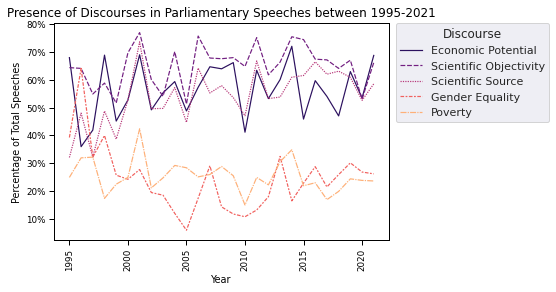

In [ ]:
# seaborn plot multiple lines
sns.set_context("paper")
sns.lineplot(data=df_final.iloc[:, :5], palette="magma")
sns.set(rc={'figure.figsize':(12, 5)})
# set the labels
plt.xlabel("Year")
sns.set(font_scale=1)
plt.ylabel("Percentage of Total Speeches")
import matplotlib.ticker as mtick
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.xticks(rotation="90")   # set here, ticks at step of 50
plt.title('Presence of Discourses in Parliamentary Speeches between 1995-2021')
plt.legend(title='Discourse', labels=['Economic Potential','Scientific Objectivity','Scientific Source','Gender Equality','Poverty'],bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()


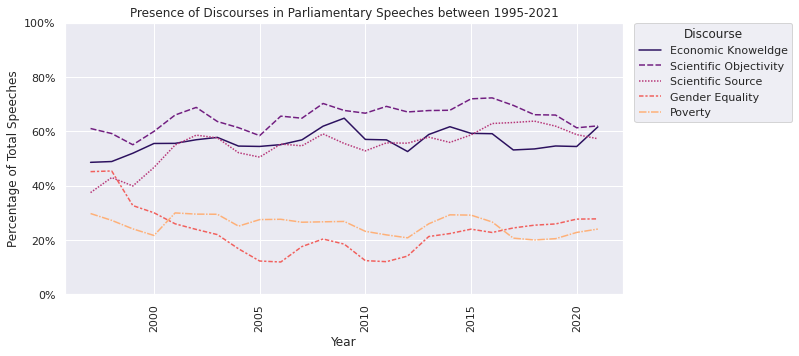

In [ ]:
#rolling trend graph
sns.lineplot(data=df_final.iloc[:, :5].rolling(3).mean(), palette="magma")
plt.xlabel("Year")
plt.ylabel("Percentage of Total Speeches")
plt.title('Presence of Discourses in Parliamentary Speeches between 1995-2021')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.legend(title='Discourse', labels=['Economic Knoweldge','Scientific Objectivity','Scientific Source','Gender Equality','Poverty'],bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xticks(rotation="90")   # set here, ticks at step of 50
sns.set(rc={'figure.figsize':(9, 5)})
plt.ylim((0,1))
plt.show()
#plt.savefig('PercentageSpeeches.jpg')
#files.download("PercentageSpeeches.jpg")

3.1.2. Discourses by Party

In [ ]:
df3['ParlGroupAbbreviation'].value_counts()

S             887
B             513
V             437
C             434
R             285
G             279
RL            269
CE             82
GL             77
CEg            73
M-E            70
E              36
BD             34
L              16
-              15
Commission      1
Name: ParlGroupAbbreviation, dtype: Int64

In [ ]:
#recode variable to factions 
df3['ParlGroupAbbreviation'] = df3['ParlGroupAbbreviation'].astype(str)
mapper={'S':'Left','B':"B",'V':'SVP',"C":"Mitte","R":"FDP","G":"GPS","RL":"FDP","CE":"Mitte","M-E":"Mitte","CEg":"Mitte","BD":"Mitte","L":"FDP", "GL":'Other',"nan":'Other',"Commission":'Other', "-":"Other"}
df3['Party'] = df3['ParlGroupAbbreviation'].map(mapper).fillna(df3['ParlGroupAbbreviation'])
print(df3['Party'].value_counts())

Left     887
Mitte    693
FDP      570
B        513
SVP      437
GPS      279
Other     93
E         36
<NA>       5
Name: Party, dtype: int64


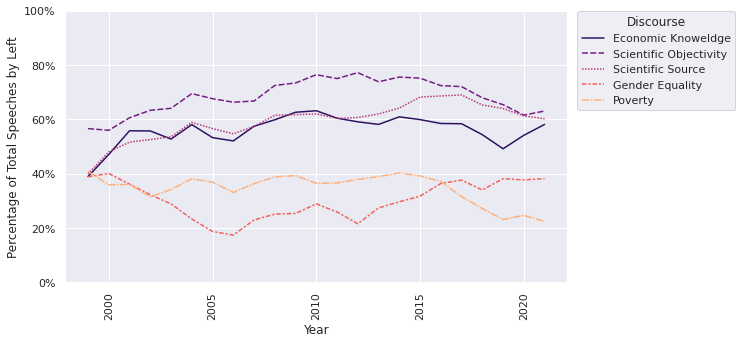

In [ ]:
#crosstab by party
SP=df3[df3['Party']=='Left']
EconPo1 = pd.crosstab(SP.yy,SP.EconPo, normalize='index')
EconPo1 = EconPo1.drop(0, axis=1)
EconPo1.rename({1: 'EconPo'}, axis=1, inplace=True)
Obj1 = pd.crosstab(SP.yy,SP.Obj, normalize='index')
Obj1 = Obj1.drop(0, axis=1)
Obj1.rename({1: 'Obj'}, axis=1, inplace=True)
Scien1 = pd.crosstab(SP.yy,SP.Scien, normalize='index')
Scien1 = Scien1.drop(0, axis=1)
Scien1.rename({1: 'Scien'}, axis=1, inplace=True)
GenDi1 = pd.crosstab(SP.yy,SP.GenDi, normalize='index')
GenDi1 = GenDi1.drop(0, axis=1)
GenDi1.rename({1: 'GenDi'}, axis=1, inplace=True)
PovConc1 = pd.crosstab(SP.yy,SP.PovConc, normalize='index')
PovConc1 = PovConc1.drop(0, axis=1)
PovConc1.rename({1: 'PovConc'}, axis=1, inplace=True)
SP1 = [EconPo1, Obj1, Scien1, GenDi1, PovConc1]
SP_final = reduce(lambda left,right: pd.merge(left,right,on='yy'), SP1)
sns.lineplot(data=SP_final.iloc[:, :5].rolling(5).mean(), palette="magma")

# set the labels
plt.xlabel("Year")
plt.ylabel("Percentage of Total Speeches by Left")
sns.set(rc={'figure.figsize':(8, 5)})
plt.legend(title='Discourse', labels=['Economic Knoweldge','Scientific Objectivity','Scientific Source','Gender Equality','Poverty'],bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.xticks(rotation="90")   # set here, ticks at step of 50
plt.ylim((0,1))
plt.show()

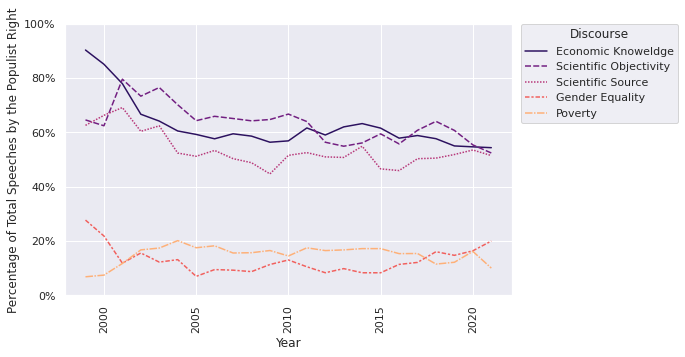

In [ ]:
#Graph for SVP
SVP=df3[df3['Party']=='SVP']
EconPo1 = pd.crosstab(SVP.yy,SVP.EconPo, normalize='index')
EconPo1 = EconPo1.drop(0, axis=1)
EconPo1.rename({1: 'EconPo'}, axis=1, inplace=True)
Obj1 = pd.crosstab(SVP.yy,SVP.Obj, normalize='index')
Obj1 = Obj1.drop(0, axis=1)
Obj1.rename({1: 'Obj'}, axis=1, inplace=True)
Scien1 = pd.crosstab(SVP.yy,SVP.Scien, normalize='index')
Scien1 = Scien1.drop(0, axis=1)
Scien1.rename({1: 'Scien'}, axis=1, inplace=True)
GenDi1 = pd.crosstab(SVP.yy,SVP.GenDi, normalize='index')
GenDi1 = GenDi1.drop(0, axis=1)
GenDi1.rename({1: 'GenDi'}, axis=1, inplace=True)
PovConc1 = pd.crosstab(SVP.yy,SVP.PovConc, normalize='index')
PovConc1 = PovConc1.drop(0, axis=1)
PovConc1.rename({1: 'PovConc'}, axis=1, inplace=True)
SVP1 = [EconPo1, Obj1, Scien1, GenDi1, PovConc1]
SVP_final = reduce(lambda left,right: pd.merge(left,right,on='yy'), SVP1)
sns.lineplot(data=SVP_final.iloc[:, :5].rolling(5).mean(), palette="magma")

# set the labels
plt.xlabel("Year")
plt.ylabel("Percentage of Total Speeches by the Populist Right")
sns.set(rc={'figure.figsize':(8, 5)})
plt.legend(title='Discourse', labels=['Economic Knoweldge','Scientific Objectivity','Scientific Source','Gender Equality','Poverty'],bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.xticks(rotation="90")   # set here, ticks at step of 50
plt.ylim((0,1))
plt.show()

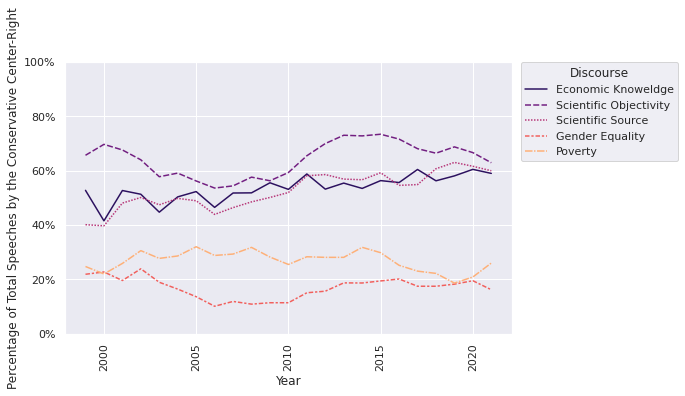

In [ ]:
#Graph for Mitte
Mitte=df3[df3['Party']=='Mitte']
EconPo1 = pd.crosstab(Mitte.yy,Mitte.EconPo, normalize='index')
EconPo1 = EconPo1.drop(0, axis=1)
EconPo1.rename({1: 'EconPo'}, axis=1, inplace=True)
Obj1 = pd.crosstab(Mitte.yy,Mitte.Obj, normalize='index')
Obj1 = Obj1.drop(0, axis=1)
Obj1.rename({1: 'Obj'}, axis=1, inplace=True)
Scien1 = pd.crosstab(Mitte.yy,Mitte.Scien, normalize='index')
Scien1 = Scien1.drop(0, axis=1)
Scien1.rename({1: 'Scien'}, axis=1, inplace=True)
GenDi1 = pd.crosstab(Mitte.yy,Mitte.GenDi, normalize='index')
GenDi1 = GenDi1.drop(0, axis=1)
GenDi1.rename({1: 'GenDi'}, axis=1, inplace=True)
PovConc1 = pd.crosstab(Mitte.yy,Mitte.PovConc, normalize='index')
PovConc1 = PovConc1.drop(0, axis=1)
PovConc1.rename({1: 'PovConc'}, axis=1, inplace=True)
Mitte1 = [EconPo1, Obj1, Scien1, GenDi1, PovConc1]
Mitte_final = reduce(lambda left,right: pd.merge(left,right,on='yy'), Mitte1)
sns.lineplot(data=Mitte_final.iloc[:, :5].rolling(5).mean(), palette="magma")

# set the labels

plt.xlabel("Year")
plt.ylabel("Percentage of Total Speeches by the Conservative Center-Right")
sns.set(rc={'figure.figsize':(8, 5)})
plt.legend(title='Discourse', labels=['Economic Knoweldge','Scientific Objectivity','Scientific Source','Gender Equality','Poverty'],bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.xticks(rotation="90")   # set here, ticks at step of 50
plt.ylim((0,1))
plt.show()

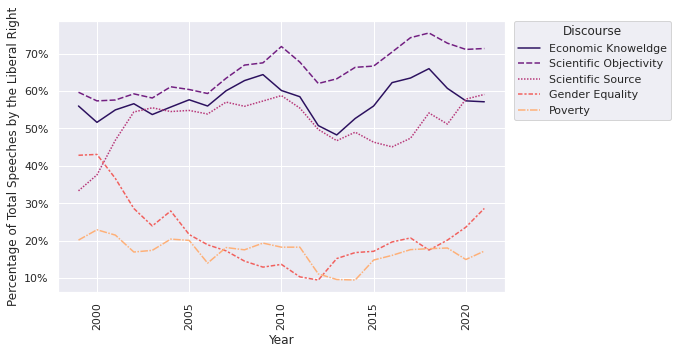

In [ ]:
#Graph for FDP
FDP=df3[df3['Party']=='FDP']
EconPo1 = pd.crosstab(FDP.yy,FDP.EconPo, normalize='index')
EconPo1 = EconPo1.drop(0, axis=1)
EconPo1.rename({1: 'EconPo'}, axis=1, inplace=True)
Obj1 = pd.crosstab(FDP.yy,FDP.Obj, normalize='index')
Obj1 = Obj1.drop(0, axis=1)
Obj1.rename({1: 'Obj'}, axis=1, inplace=True)
Scien1 = pd.crosstab(FDP.yy,FDP.Scien, normalize='index')
Scien1 = Scien1.drop(0, axis=1)
Scien1.rename({1: 'Scien'}, axis=1, inplace=True)
GenDi1 = pd.crosstab(FDP.yy,FDP.GenDi, normalize='index')
GenDi1 = GenDi1.drop(0, axis=1)
GenDi1.rename({1: 'GenDi'}, axis=1, inplace=True)
PovConc1 = pd.crosstab(FDP.yy,FDP.PovConc, normalize='index')
PovConc1 = PovConc1.drop(0, axis=1)
PovConc1.rename({1: 'PovConc'}, axis=1, inplace=True)
FDP1 = [EconPo1, Obj1, Scien1, GenDi1, PovConc1]
FDP_final = reduce(lambda left,right: pd.merge(left,right,on='yy'), FDP1)
sns.lineplot(data=FDP_final.iloc[:, :5].rolling(5).mean(), palette="magma")

# set the labels
plt.xlabel("Year")
plt.ylabel("Percentage of Total Speeches by the Liberal Right")
sns.set(rc={'figure.figsize':(8, 5)})
plt.legend(title='Discourse', labels=['Economic Knoweldge','Scientific Objectivity','Scientific Source','Gender Equality','Poverty'],bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.xticks(rotation="90")   # set here, ticks at step of 50
plt.show()

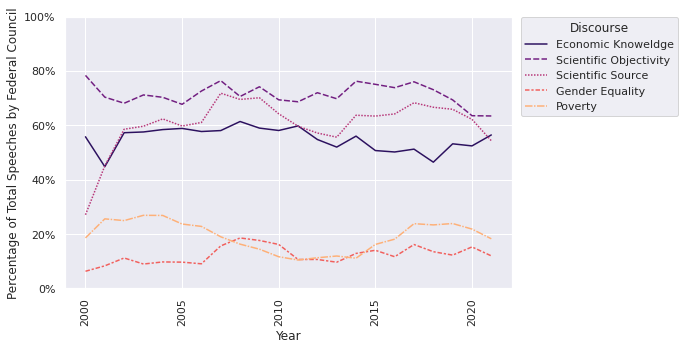

In [ ]:
#Graph for Bundesrat
B=df3[df3['Party']=='B']
EconPo1 = pd.crosstab(B.yy,B.EconPo, normalize='index')
EconPo1 = EconPo1.drop(0, axis=1)
EconPo1.rename({1: 'EconPo'}, axis=1, inplace=True)

Obj1 = pd.crosstab(B.yy,B.Obj, normalize='index')
Obj1 = Obj1.drop(0, axis=1)
Obj1.rename({1: 'Obj'}, axis=1, inplace=True)
Scien1 = pd.crosstab(B.yy,B.Scien, normalize='index')
Scien1 = Scien1.drop(0, axis=1)
Scien1.rename({1: 'Scien'}, axis=1, inplace=True)
GenDi1 = pd.crosstab(B.yy,B.GenDi, normalize='index')
GenDi1 = GenDi1.drop(0, axis=1)
GenDi1.rename({1: 'GenDi'}, axis=1, inplace=True)
PovConc1 = pd.crosstab(B.yy,B.PovConc, normalize='index')
PovConc1 = PovConc1.drop(0, axis=1)
PovConc1.rename({1: 'PovConc'}, axis=1, inplace=True)
B1 = [EconPo1, Obj1, Scien1, GenDi1, PovConc1]
B_final = reduce(lambda left,right: pd.merge(left,right,on='yy'), B1)

sns.lineplot(data=B_final.iloc[:, :5].rolling(4).mean(), palette="magma")

# set the labels

plt.xlabel("Year")
plt.ylabel("Percentage of Total Speeches by Federal Council")
sns.set(rc={'figure.figsize':(8, 5)})
plt.legend(title='Discourse', labels=['Economic Knoweldge','Scientific Objectivity','Scientific Source','Gender Equality','Poverty'],bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.xticks(rotation="90")   # set here, ticks at step of 50
plt.ylim((0,1))
plt.show()

3.1.3 Economic Discourses by Part

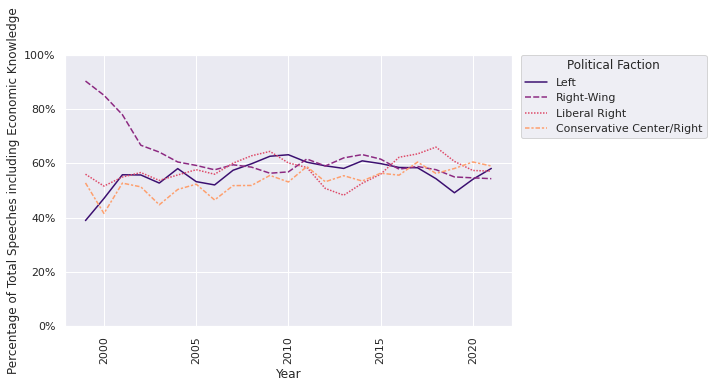

In [ ]:
SPEcon=df3[df3['Party']=='Left']
SPEconPo = pd.crosstab(SPEcon.yy,SPEcon.EconPo, normalize='index')
SPEconPo = SPEconPo.drop(0, axis=1)
SPEconPo.rename({1: 'SP'}, axis=1, inplace=True)

SVPEcon=df3[df3['Party']=='SVP']
SVPEcon = pd.crosstab(SVPEcon.yy,SVPEcon.EconPo, normalize='index')
SVPEcon = SVPEcon.drop(0, axis=1)
SVPEcon.rename({1: 'SVP'}, axis=1, inplace=True)

FDPEcon=df3[df3['Party']=='FDP']
FDPEcon = pd.crosstab(FDPEcon.yy,FDPEcon.EconPo, normalize='index')
FDPEcon = FDPEcon.drop(0, axis=1)
FDPEcon.rename({1: 'FDP'}, axis=1, inplace=True)

MitteEcon=df3[df3['Party']=='Mitte']
MitteEcon = pd.crosstab(MitteEcon.yy,MitteEcon.EconPo, normalize='index')
MitteEcon = MitteEcon.drop(0, axis=1)
MitteEcon.rename({1: 'Mitte'}, axis=1, inplace=True)

Econ = [SPEconPo, SVPEcon, FDPEcon, MitteEcon]
Econ_final = reduce(lambda left,right: pd.merge(left,right,on='yy'), Econ)

sns.lineplot(data=Econ_final.iloc[:, :5].rolling(5).mean(), palette="magma")

# set the labels

plt.xlabel("Year")
plt.ylabel("Percentage of Total Speeches including Economic Knowledge")
sns.set(rc={'figure.figsize':(8, 5)})
plt.legend(title='Political Faction', labels=['Left','Right-Wing','Liberal Right','Conservative Center/Right',],bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.xticks(rotation="90")
plt.ylim((0,1))   # set here, ticks at step of 50
plt.show()


3.1.4 Scientific Discourses by Party

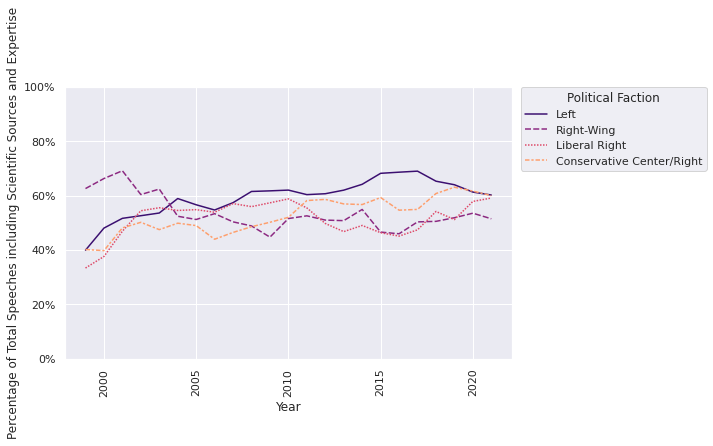

In [ ]:
SPScien=df3[df3['Party']=='Left']
SPScien = pd.crosstab(SPScien.yy,SPScien.Scien, normalize='index')
SPScien = SPScien.drop(0, axis=1)
SPScien.rename({1: 'SP'}, axis=1, inplace=True)

SVPScien=df3[df3['Party']=='SVP']
SVPScien= pd.crosstab(SVPScien.yy,SVPScien.Scien, normalize='index')
SVPScien = SVPScien.drop(0, axis=1)
SVPScien.rename({1: 'SVP'}, axis=1, inplace=True)

FDPScien=df3[df3['Party']=='FDP']
FDPScien = pd.crosstab(FDPScien.yy,FDPScien.Scien, normalize='index')
FDPScien = FDPScien.drop(0, axis=1)
FDPScien.rename({1: 'FDP'}, axis=1, inplace=True)

MitteScien=df3[df3['Party']=='Mitte']
MitteScien = pd.crosstab(MitteScien.yy,MitteScien.Scien, normalize='index')
MitteScien = MitteScien.drop(0, axis=1)
MitteScien.rename({1: 'Mitte'}, axis=1, inplace=True)

Scien = [SPScien, SVPScien, FDPScien, MitteScien]
Scien_final = reduce(lambda left,right: pd.merge(left,right,on='yy'), Scien)

sns.lineplot(data=Scien_final.iloc[:, :5].rolling(5).mean(), palette="magma")

# set the labels

plt.xlabel("Year")
plt.ylabel("Percentage of Total Speeches including Scientific Sources and Expertise")
sns.set(rc={'figure.figsize':(8, 5)})
plt.legend(title='Political Faction', labels=['Left','Right-Wing','Liberal Right','Conservative Center/Right',],bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.xticks(rotation="90")
plt.ylim((0,1))   # set here, ticks at step of 50
plt.show()


3.1.5 Gender Discourses by Party 

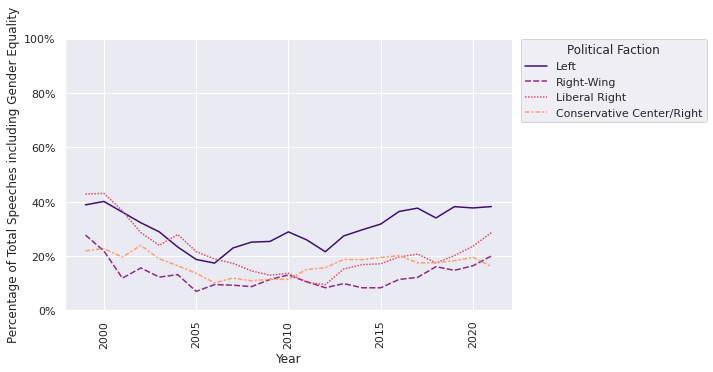

In [ ]:
SPGenDi=df3[df3['Party']=='Left']
SPGenDi = pd.crosstab(SPGenDi.yy,SPGenDi.GenDi, normalize='index')
SPGenDi = SPGenDi.drop(0, axis=1)
SPGenDi.rename({1: 'SP'}, axis=1, inplace=True)

SVPGenDi=df3[df3['Party']=='SVP']
SVPGenDi= pd.crosstab(SVPGenDi.yy,SVPGenDi.GenDi, normalize='index')
SVPGenDi = SVPGenDi.drop(0, axis=1)
SVPGenDi.rename({1: 'SVP'}, axis=1, inplace=True)

FDPGenDi=df3[df3['Party']=='FDP']
FDPGenDi = pd.crosstab(FDPGenDi.yy,FDPGenDi.GenDi, normalize='index')
FDPGenDi = FDPGenDi.drop(0, axis=1)
FDPGenDi.rename({1: 'FDP'}, axis=1, inplace=True)

MitteGenDi=df3[df3['Party']=='Mitte']
MitteGenDi = pd.crosstab(MitteGenDi.yy,MitteGenDi.GenDi, normalize='index')
MitteGenDi = MitteGenDi.drop(0, axis=1)
MitteGenDi.rename({1: 'Mitte'}, axis=1, inplace=True)

GenDi = [SPGenDi, SVPGenDi, FDPGenDi, MitteGenDi]
GenDi_final = reduce(lambda left,right: pd.merge(left,right,on='yy'), GenDi)

sns.lineplot(data=GenDi_final.iloc[:, :5].rolling(5).mean(), palette="magma")

# set the labels

plt.xlabel("Year")
plt.ylabel("Percentage of Total Speeches including Gender Equality")
sns.set(rc={'figure.figsize':(8, 5)})
plt.legend(title='Political Faction', labels=['Left','Right-Wing','Liberal Right','Conservative Center/Right',],bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.xticks(rotation="90")   # set here, ticks at step of 50
plt.ylim((0,1))
plt.show()

3.1.6 Poverty Discourses by Party 

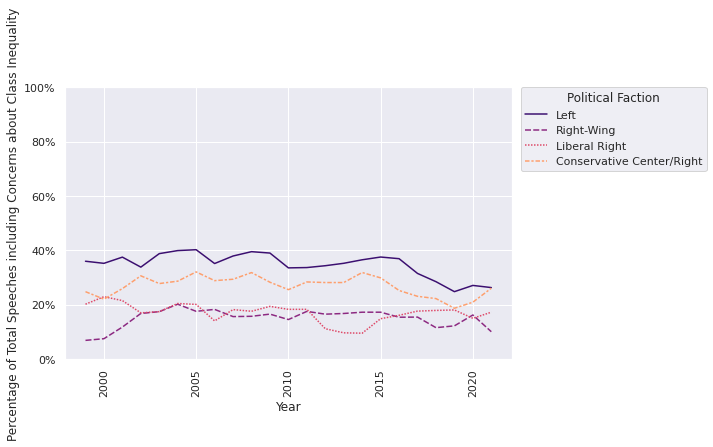

In [ ]:
SPPovConc=df3[df3['Party']=='Left']
SPPovConc = pd.crosstab(SPPovConc.yy,SPPovConc.PovConc, normalize='index')
SPPovConc= SPPovConc.drop(0, axis=1)
SPPovConc.rename({1: 'SP'}, axis=1, inplace=True)

SVPPovConc=df3[df3['Party']=='SVP']
SVPPovConc= pd.crosstab(SVPPovConc.yy,SVPPovConc.PovConc, normalize='index')
SVPPovConc = SVPPovConc.drop(0, axis=1)
SVPPovConc.rename({1: 'SVP'}, axis=1, inplace=True)

FDPPovConc=df3[df3['Party']=='FDP']
FDPPovConc = pd.crosstab(FDPPovConc.yy,FDPPovConc.PovConc, normalize='index')
FDPPovConc = FDPPovConc.drop(0, axis=1)
FDPPovConc.rename({1: 'FDP'}, axis=1, inplace=True)

MittePovConc=df3[df3['Party']=='Mitte']
MittePovConc = pd.crosstab(MittePovConc.yy,MittePovConc.PovConc, normalize='index')
MittePovConc = MittePovConc.drop(0, axis=1)
MittePovConc.rename({1: 'Mitte'}, axis=1, inplace=True)

PovConc = [SPPovConc, SVPPovConc, FDPPovConc, MittePovConc]
PovConc_final = reduce(lambda left,right: pd.merge(left,right,on='yy'), PovConc)

sns.lineplot(data=PovConc_final.iloc[:, :5].rolling(5).mean(), palette="magma")

# set the labels

plt.xlabel("Year")
plt.ylabel("Percentage of Total Speeches including Concerns about Class Inequality")
sns.set(rc={'figure.figsize':(8, 5)})
plt.legend(title='Political Faction', labels=['Left','Right-Wing','Liberal Right','Conservative Center/Right',],bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.xticks(rotation="90")   # set here, ticks at step of 50
plt.ylim((0,1))
plt.show()

3.1.7 Correlation between Scien and Gen, Scien and Econ, Scien and PovConc

In [ ]:
df3['EconPo'] = pd.to_numeric(df3['EconPo'])
df3['Obj'] = pd.to_numeric(df3['Obj'])
df3['Scien'] = pd.to_numeric(df3['Scien'])
df3['GenDi'] = pd.to_numeric(df3['GenDi'])
df3['PovConc'] = pd.to_numeric(df3['PovConc'])

In [ ]:
labels = df3[['EconPo','Obj','Scien','GenDi','PovConc']]
labels

,EconPo,Obj,Scien,GenDi,PovConc
ID,,,,,
2,1,0,1,0,1
3,0,1,0,0,1
4,0,0,0,0,0
5,1,0,1,0,0
6,0,0,1,0,1
...,...,...,...,...,...
292766,0,0,0,0,0
292812,1,0,0,0,0
292819,1,0,1,0,0


In [ ]:
#calculate piersons correlation between (binary) labels
table=labels.corr(method='pearson')

In [ ]:
np.round(table, decimals=2)

,EconPo,Obj,Scien,GenDi,PovConc
EconPo,1.00,0.33,0.32,0.06,0.17
Obj,0.33,1.00,0.30,0.12,0.18
Scien,0.32,0.30,1.00,0.12,0.21
GenDi,0.06,0.12,0.12,1.00,0.08
PovConc,0.17,0.18,0.21,0.08,1.00


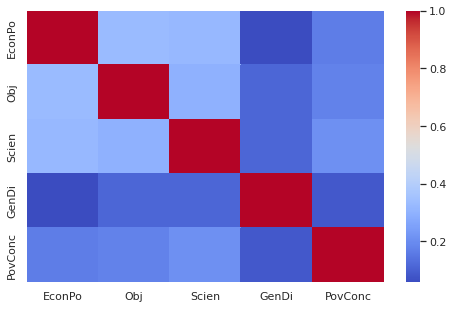

In [ ]:
#create heatmap 
colormap= sns.color_palette("coolwarm", as_cmap=True)
# colormap= sns.color_palette("vlag", as_cmap=True)
sns.heatmap(table, cmap=colormap)

Correlation over time

In [ ]:
 df3['yy'].astype(int)

ID
2         1995
3         1995
4         1995
5         1996
6         1996
          ... 
292766    2021
292812    2021
292819    2021
292848    2021
293359    2021
Name: yy, Length: 3513, dtype: int64

In [ ]:
Time1 = df3[(df3['yy'] > 1994) & (df3['yy'] <= 2000)]
Time2 = df3[(df3['yy'] > 2000) & (df3['yy'] <= 2005)]
Time3 = df3[(df3['yy'] > 2005) & (df3['yy'] <= 2010)]
Time4 = df3[(df3['yy'] > 2010) & (df3['yy'] <= 2015)]
Time5 = df3[(df3['yy'] > 2015) & (df3['yy'] <= 2021)]

In [ ]:
labels1 = Time1[['EconPo','Obj','Scien','GenDi','PovConc']]
table1=labels1.corr(method='pearson')
labels2 = Time2[['EconPo','Obj','Scien','GenDi','PovConc']]
table2=labels2.corr(method='pearson')
labels3 = Time3[['EconPo','Obj','Scien','GenDi','PovConc']]
table3=labels3.corr(method='pearson')
labels4 = Time4[['EconPo','Obj','Scien','GenDi','PovConc']]
table4=labels4.corr(method='pearson')
labels5 = Time5[['EconPo','Obj','Scien','GenDi','PovConc']]
table5=labels5.corr(method='pearson')

In [ ]:
np.round(table1, decimals=2)

,EconPo,Obj,Scien,GenDi,PovConc
EconPo,1.00,0.37,0.39,-0.04,0.13
Obj,0.37,1.00,0.36,0.12,0.18
Scien,0.39,0.36,1.00,0.03,0.22
GenDi,-0.04,0.12,0.03,1.00,0.07
PovConc,0.13,0.18,0.22,0.07,1.00


In [ ]:
np.round(table2, decimals=2)

,EconPo,Obj,Scien,GenDi,PovConc
EconPo,1.00,0.36,0.39,0.01,0.18
Obj,0.36,1.00,0.34,0.13,0.22
Scien,0.39,0.34,1.00,0.13,0.23
GenDi,0.01,0.13,0.13,1.00,0.14
PovConc,0.18,0.22,0.23,0.14,1.00


In [ ]:
np.round(table3, decimals=2)

,EconPo,Obj,Scien,GenDi,PovConc
EconPo,1.00,0.30,0.27,0.07,0.14
Obj,0.30,1.00,0.27,0.14,0.13
Scien,0.27,0.27,1.00,0.15,0.19
GenDi,0.07,0.14,0.15,1.00,0.09
PovConc,0.14,0.13,0.19,0.09,1.00


In [ ]:
np.round(table4, decimals=2)

,EconPo,Obj,Scien,GenDi,PovConc
EconPo,1.00,0.27,0.24,0.03,0.16
Obj,0.27,1.00,0.26,0.06,0.18
Scien,0.24,0.26,1.00,0.08,0.19
GenDi,0.03,0.06,0.08,1.00,0.10
PovConc,0.16,0.18,0.19,0.10,1.00


In [ ]:
np.round(table5, decimals=2)

,EconPo,Obj,Scien,GenDi,PovConc
EconPo,1.00,0.32,0.30,0.15,0.20
Obj,0.32,1.00,0.28,0.14,0.16
Scien,0.30,0.28,1.00,0.15,0.23
GenDi,0.15,0.14,0.15,1.00,0.05
PovConc,0.20,0.16,0.23,0.05,1.00
